# Financial Modeling Samples
## Henry Beck

### This file
This notebook is intended to include some quick examples of Monte Carlo methods used in financial modeling implemented with minimal use of outside libraries. 

Examples represent original work done in the context of computational finance coursework

### IPMsolver.py

'IPMsolver.py' is a nascent implementation of the interior points method for asset allocation optimization problems.
It is rougher than my best work since I am still early in the process of development, but I include it as I want to showcase some finance related python examples that involved at least basic OOP. Originally this project was motivated, by the desire to better understand and efficiently solve semi-definite programs as SDP can allow for the simulataneous inclusion multiple coherent risk measures and the tracking of benchmarks when constructing an optimized portfolio. Currently, I have only built it out to solve the special case of a quadratic program. Unfortunately, I am uncertain that I will complete this project as 6 days ago CVXPY added semi-definite program support using Clarabel, an opensource interior points method solver.

# Examples below

In [10]:
import numpy as np
from matplotlib import pyplot as plt

## Monte Carlo Simulations
Below is the simulation of the value of an underlying asset in order to determine the value of discretely monitored Asian call option. First simulating an option which calculates payoff using a geometric mean, then simulating an option with idential parameters but with payoff calculated using an arithmetic mean. I will apply the antithetic variables method for variance reduction to the geometric option, and then use the estimated value of the geometric option as a control variate to reduce variance for the arithmetic option.

The parameters for the option we will be using are 
$$\begin{aligned}
S_0 &= 50,\: K = 50, \\
T &= 1,\: n = 5 \\
r &= 0.05,\: \sigma = 0.2
\end{aligned}$$




In [4]:
# Helper function to generate normally distributed random variables using Box-Mueller
pi = np.pi
def BoxMull_Normal(n):
    Z = np.random.uniform(0,1,size =n)
    V = -2*np.log(1-Z)
    W = np.random.uniform(0,2*pi, size = n)
    x = np.sqrt(V)*np.cos(W)
    y = np.sqrt(V)*np.sin(W)
    return x,y

In [5]:
S0 = 50
K = 50
T = 1
n = 5
r = 0.05
sig = 0.2

N = 100000
z = 1.96

In [6]:
S = np.zeros((int(2*N),n+1))
S[:,0] = S0
dt = T/n

### Simulation for the geometric mean

In [8]:
# simulating the underlying asset
S = np.zeros((int(N),n+1))
Sy = np.zeros((int(N),n+1))
S[:,0] = S0
Sy[:,0] = S0
#rho = -0.5
#Sigma = np.array([[sig ** 2, rho * sig**2], [rho * sig**2, sig ** 2]])
#A = np.linalg.cholesky(Sigma)


for j in range(int(N)):
    Z = BoxMull_Normal(n+1)[0]
    #Zy = BoxMull_Normal(n+1)[1]
    #Z = np.random.randn(n)
    #Zy = np.random.randn(n)
    for i in range(1,n+1):
         #Z = BoxMull_Normal(1)
         #Z = A@Z
         s_increment = (r - sig ** 2 / 2) * dt + sig * np.sqrt(dt) * Z[i]
         S[j,i] = S[j,i-1]*np.exp(s_increment)
         sy_increment = (r - sig ** 2 / 2) * dt + sig * np.sqrt(dt) * -Z[i]
         Sy[j,i] = Sy[j,i-1]*np.exp(sy_increment)

# Geometric Mean
S_g = S[:,1:].prod(axis = 1)**(1/n)
S_gy = Sy[:,1:].prod(axis = 1)**(1/n)

# Max mean or 0
max_S_0 = S_g-K
max_S_0 = ((S_g-K) > 0)*(S_g-K)
max_Sy_0 = ((S_gy-K) > 0)*(S_gy-K)

# Calculate the samples of X
X = np.exp(-r*T) * max_S_0
Y = np.exp(-r*T) * max_Sy_0
#Y = -X
avg = (X+Y)/2

# estimate
theta = np.mean(avg)
var = np.var(avg)
err_anti = z*np.sqrt(var / (N))
std_B = np.std(avg)

CI_up  = theta + err_anti
CI_low = theta - err_anti

print("Our estimate: {}".format(theta))
print("Confidence Interval\n Low: {:.5f}\n High: {:.5f}".format(CI_low,CI_up))
print("Our CI half length: {}".format(err_anti))

Our estimate: 3.250613769369383
Confidence Interval
 Low: 3.23681
 High: 3.26442
Our CI half length: 0.013806159851738761


### Arithmetic mean

In [9]:
N = 100000
S = np.zeros((int(2*N),n+1))
S[:,0] = S0
dt = T/n

# simulating the underlying asset
for j in range(int(2*N)):
    Z = BoxMull_Normal(n+1)[0]
    #Z = np.random.randn(n)
    for i in range(1,n+1):
         s_increment = (r - sig ** 2 / 2) * dt + sig * np.sqrt(dt) * Z[i]
         S[j,i] = S[j,i-1]*np.exp(s_increment)

# Arithmetic Mean
S_a = S[:,1:].sum(axis = 1)*(1/n)

# Max mean or 0
max_S_0 = S_a-K
max_S_0 = ((S_a-K) > 0)*(S_a-K)

# Calculate the samples of X
Xa = np.exp(-r*T) * max_S_0

# Geometric Mean
S_g = S[:,1:].prod(axis = 1)**(1/n)

# Max mean or 0
max_S_0 = S_g-K
max_S_0 = ((S_g-K) > 0)*(S_g-K)

# Calculate the samples of X
Xg = np.exp(-r*T) * max_S_0

# Ctrl Variate
mu_g = np.mean(Xg)
Xg_var = np.var(Xg)
Cov = np.cov(Xa,Xg)[0,1]
c = -Cov/Xg_var
Ctrl_Variate = c*(Xg - mu_g)


estimator = Xa + Ctrl_Variate
theta = np.mean(estimator)
var = np.var(estimator)
err_ctrl = z*np.sqrt(var / (N))



CI_up  = theta + err_ctrl
CI_low = theta - err_ctrl

print("Our estimate: {}".format(theta))
print("Confidence Interval\n Low: {:.5f}\n High: {:.5f}".format(CI_low,CI_up))
print("Our CI half length: {}".format(err_ctrl))

Our estimate: 3.364984096839246
Confidence Interval
 Low: 3.36416
 High: 3.36581
Our CI half length: 0.0008220782656019698


## Simulation of a Jump Diffusion process
Here I will simulate $X_t$ and $Y_t$. These are two jump diffusion processes governed by

$$\begin{aligned}
\textrm{d}X_t &= \mu_1 X_t\,\textrm{d}t + \sigma_1 X_t\,\textrm{d}W^{(1)}_t + X_t\,\textrm{d}J_t \\
\textrm{d}Y_t &= \mu_2 Y_t\,\textrm{d}t + \sigma_2 Y_t\,\textrm{d}W^{(2)}_t + Y_t\,\textrm{d}J_t
\end{aligned}$$

where $W^{(1)}_t$ and $W^{(2)}_t$ are two i.i.d. Brownian motions and

$$J_t = \sum_{i = 1}^{N_t}\left(e^{X_i} - 1\right)$$

where $N_t\sim\textrm{Poisson}(\lambda)$ and the $X_i\sim N(0, 1)$ are i.i.d. standard normals. Note they are using the same jump process but have independent Geometric Brownian Motion paths.

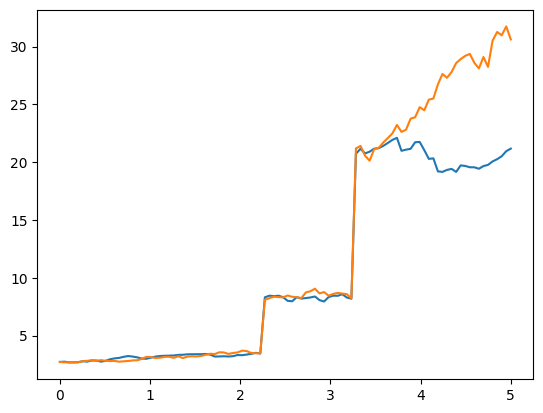

In [17]:
mu_1  = 0.1
mu_2  = 0.1
sig_1 = 0.1
sig_2 = 0.1
lam   = 0.2
X_0   = 1
Y_0   = 1

T = 5
t_0 = 0
n = 100
dt = (T - t_0)/100

lnX = np.zeros(n)
lnY = np.zeros(n)
lnX[0] = X_0
lnY[0] = Y_0

for i in range(1,n):
    num_jumps = np.random.poisson(lam*dt)
    jum_mag = np.random.randn(num_jumps)
    z = np.random.randn(2) 
    dx = (mu_1 - sig_1**2/2)*dt +sig_1*np.sqrt(dt)*z[0]
    dy = (mu_2 - sig_2**2/2)*dt +sig_2*np.sqrt(dt)*z[1]
    lnX[i] = lnX[i-1] + dx
    lnY[i] = lnY[i-1] + dy
    for k in range(num_jumps):
        lnX[i] += jum_mag[k]
        lnY[i] += jum_mag[k]

X = np.exp(lnX)
Y = np.exp(lnY)

plt.plot(np.linspace(t_0,T,n),X,np.linspace(t_0,T,n),Y)

##